# Code to Plot results of CEF fit to $\rm{Nd_3Sb_3Mg_2O_{14}}$ data

Allen Scheie
December, 2017

at this point, we've fit a point charge model and then fit the CEF parameters directly.

In [1]:
# Import libraries
%matplotlib notebook
# Import libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
import sys
sys.path.append('/home/allen/Documents/Python/Modules')
import CEF_calculations as cef
import time


#Plot Formatting stuff
#########################################################################
#mpl.style.use('default')
import seaborn.apionly as sns
from cycler import cycler
cpal1 = sns.choose_colorbrewer_palette('qualitative')

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans',
          'xtick.direction':'in', 'ytick.direction': 'in',
          'xtick.top': True,'ytick.right': True,
          'font.size': 15, 'axes.prop_cycle': cycler('color',cpal1)}
plt.rcParams.update(params)

def my_formatter(x, pos):
    """Format 0.0 as 0"""
    if x == 0.00: return '{:g}'.format(x)
    else: return x
#########################################################################


# Put the above values for the Debye Waller factor in a dictionary
AtomDisp = {}
AtomDisp['NdMg'] = {}
AtomDisp['NdMg'][6] = 0.0
AtomDisp['NdMg'][100] = 0.045148437500000055
AtomDisp['NdMg'][200] = 0.084953125000000129

AtomDisp['NdZn'] = {}
AtomDisp['NdZn'][6] = 0.0
AtomDisp['NdZn'][100] = 0.045175781250000054
AtomDisp['NdZn'][200] = 0.087765625000000125

AtomDisp['PrMg'] = {}
AtomDisp['PrMg'][6] = 0.0
AtomDisp['PrMg'][100] = 0.045941406250000053
AtomDisp['PrMg'][200] = 0.076910156250000111



# Import Resolution Function

resf150 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc150.txt', skip_header=1, unpack=True)
resf80 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc80.txt', skip_header=1, unpack=True)
resf40 = np.genfromtxt('./Data/ResolutionFunction/'+
                        'ResFunc40.txt', skip_header=1, unpack=True)

def resfunc(Ei, deltaE):
    if Ei == 150:
        deltaE = np.interp(deltaE, resf150[0], resf150[1])
    elif Ei == 80:
        deltaE =  np.interp(deltaE, resf80[0], resf80[1])
    elif Ei == 40:
        deltaE =  np.interp(deltaE, resf40[0], resf40[1])
    else: print("Ei not in resfunc data.")
    return deltaE



# Test out NeutronSpectrum2D function
Qarray = np.arange(0.1,15,0.1)
Earray = np.arange(5,150,0.5)

def arrayedges(xarray):
    diff = (xarray[1:] - xarray[:-1]) / 2.  # get edges of arrays
    return np.hstack((xarray[0]-diff[0], xarray[:-1]+diff, xarray[-1]+diff[-1]))
Eedges = arrayedges(Earray)
Qedges = arrayedges(Qarray)

/home/allen/anaconda3/lib/python3.6/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


A Jupyter Widget

[6, 6, 6, 100, 100, 100, 200, 200, 200]
[40, 80, 150, 40, 80, 150, 40, 80, 150]


<IPython.core.display.Javascript object>


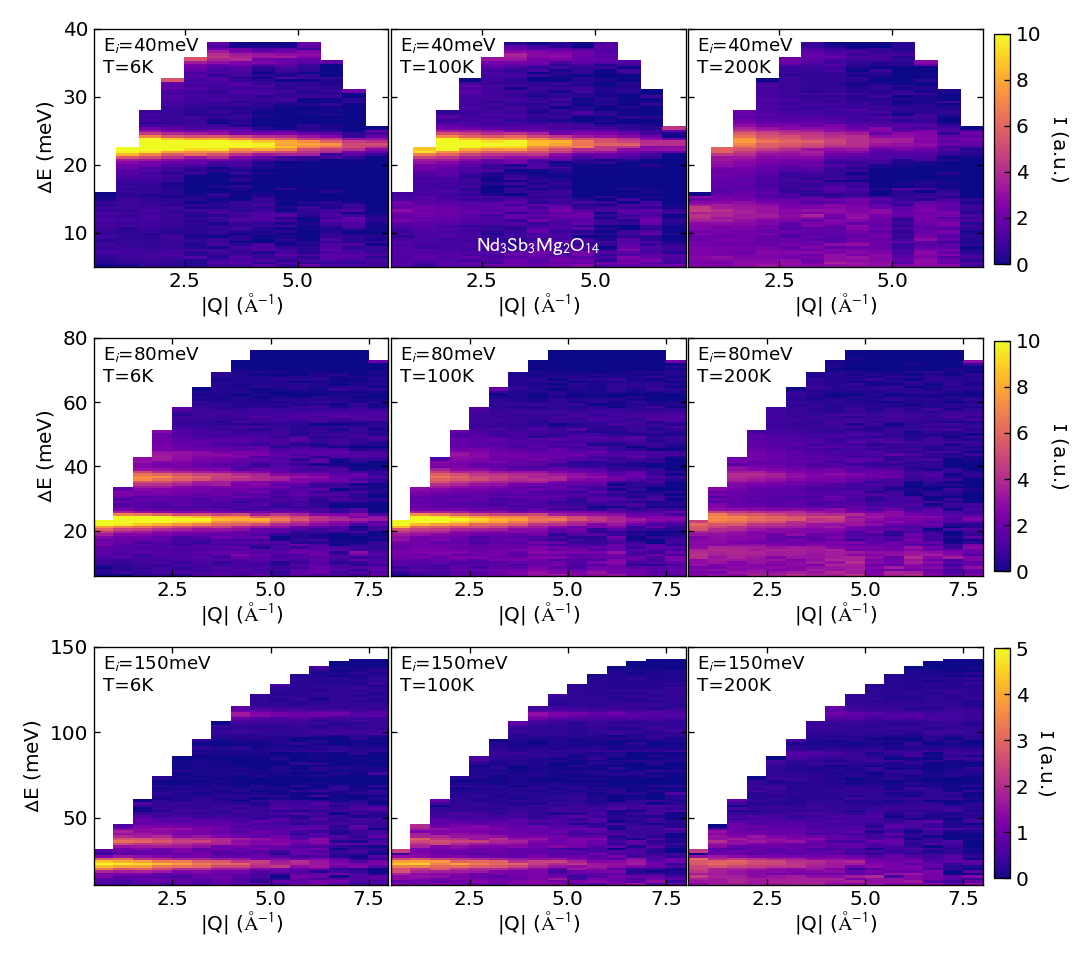

/home/allen/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [2]:
### Import Susceptibility data
# Import data
datafile = './Data/'+\
                'Nd3Sb3Mg2O14 MT 1.8 to 300 5000 oe 53.8 mg.dc.dat'
#ImportData
DataA = np.genfromtxt(datafile, delimiter=',', skip_header=31)
Temp = DataA[:,3]
Mag = DataA[:,4]

#Normalize the data
mass = 0.0538 #mass in g of sample
Molarmass = 3*144.242 + 3*121.76 + 2*24.305 + 14*15.9994  #molar mass of sample (g/mol)
field = 5000

NormMag = Mag / mass * Molarmass / 3 / field
Chiminus1 = 1/NormMag  # in emu/Oe/mol
Chiminus1 *= 1/(1.078283e20*10000/6.0221409e23)  # in mu_B/T/ion



# Import data
slicesdirectory = './Data/Slices/'

# Define file names by my naming convention
filenames = []
for T in [6, 100, 200]:
    for E in [40,80,150]:
        filenames.append('NdMg_T'+str(T)+'_E'+str(E)+'_slice.iexy')

data = [cef.importGridfile(slicesdirectory+f) for i,f in enumerate(filenames)]
# # Intensity Error |Q| DeltaE

datatemps = [int(name.split('_')[1][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION
dataengys = [int(name.split('_')[2][1:]) for name in filenames] # THIS IS PARTICULAR TO MY NAMING CONVENTION

print(datatemps)
print(dataengys)

#print data[1][0]



ntemps = len(set(datatemps))
nengys = len(set(dataengys))


plt.rc('font',**{'size':12})
    
f, ax = plt.subplots(3,3, figsize=(9,8))


cax1 = f.add_axes([0.92,0.725,0.015,0.24])
cax2 = f.add_axes([0.92,0.405,0.015,0.24])
cax3 = f.add_axes([0.92,0.085,0.015,0.24])
cax = [cax1, cax2, cax3]

minImaxI = [(0,0.001),(0,0.001),(0,0.0005)]
cmap = 'plasma'
for i in range(nengys):
    minI, maxI = minImaxI[i]
    for j in range(ntemps):
        k = j*ntemps + i
        try: 
            intensity = np.ma.masked_where(np.isnan(data[k]['I']), data[k]['I'])
            ax[i,j].pcolormesh(arrayedges(data[k]['Q']), arrayedges(data[k]['E']), intensity, 
                               rasterized = True, cmap = cmap, vmin = minI, vmax = maxI)
            # Set axis labels
            if j == 0: ax[i,j].set_ylabel('$\Delta$E (meV)')
            else: ax[i,j].yaxis.set_ticklabels([])
            ax[i,j].set_xlabel('|Q| ($\\rm \AA^{-1}$)', labelpad=0)
            # set text in frame
            ax[i,j].text(0.03, 0.97, 'E$_i$='+str(dataengys[k])+'meV'+'\nT='+str(datatemps[k])+'K', fontsize=11,
                        horizontalalignment='left',verticalalignment='top', transform=ax[i,j].transAxes)
        except IndexError:
            break
            
    norm = Normalize(vmin=minI*1e4, vmax=maxI*1e4)
    mappable = cm.ScalarMappable(norm = norm, cmap=cmap)
    mappable.set_array([])
    cb = f.colorbar(mappable, cax[i], cmap =cmap, norm=norm ,orientation='vertical',
                       ticklocation = 'right',drawedges = False)
    cb.solids.set_edgecolor("face")
    #cb.set_ticks(MultipleLocator(0.02))
    cb.formatter.set_powerlimits((-1, 2))
    cb.ax.xaxis.set_label_coords(1.24,0.6)
    #cb.ax.xaxis.set_major_formatter(FormatStrFormatter('%f'))
    cb.set_label('$\\rm I$ (a.u.)', rotation = -90, labelpad = 17)

ax[0,1].text(0.5,0.04,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$', color='w',
    horizontalalignment='center',verticalalignment='bottom', transform=ax[0,1].transAxes)
    
plt.tight_layout()
f.subplots_adjust(wspace=0.01, hspace=0.3, right=0.91)
plt.show()

In [3]:
### Import La  Susceptibility data
# Import data
Ladatafile = './Data/'+\
                'La3Sb3Mg2O14_24.4mg_MT_4_12_17.dat'

TempLa, MagLa = [], []
for line in open(Ladatafile):
    try:
        dataaa = line.split(',')
        MagLa.append(float(dataaa[4]))
        TempLa.append(float(dataaa[2]))
    except (IndexError, ValueError) as e: pass
#ImportData
TempLa = np.array(TempLa)
MagLa = np.array(MagLa)

#Normalize the data
massLa = 0.0244 #mass in g of sample
MolarmassLa = 3*138.905 + 3*121.76 + 2*24.305 + 14*15.9994  #molar mass of sample (g/mol)
fieldLa = 5000

NormMagLa = MagLa / massLa * MolarmassLa / 3 / fieldLa
Chiminus1La = 1/NormMagLa  # in emu/Oe/mol
Chiminus1La *= 1/(1.078283e20*10000/6.0221409e23)  # in mu_B/T/ion

In [4]:
import pickle

with open('./intermediateCoupling/'+\
          'CEF_ND_fitResults.pickle', 'rb') as f:
    FitCoefRes1, FitGamma, FitPrefactors = pickle.load(f)

# Build Hamiltonian from fit coefficients
# Build Hamiltonian, ignoring the negative stevens operators (because they shouldn't be allowed by symmetry).
ionJ = cef.Jion['Nd3+']
# Spin orbit coupling strength = hc * First Excited Multiplet Energy (in cm) / 5.5
SOCstrength = 1.23984193e-1 * 1936 / 5.5
print(ionJ)

i=0
Nd_O = []
for n in range(2,8,2):
    for m in range(0,n+1):
        #print(n,m, Coefficients[i])
        Nd_O.append(  cef.LS_StevensOp(ionJ[1],ionJ[0],n,m)  )
        i+=1

NdCoefFit1 = cef.LS_CFLevels(Nd_O, FitCoefRes1['coeff'], ionJ[1], ionJ[0], SOCstrength)
NdCoefFit1.diagonalize()
NdCoefFit1.printEigenvectors()
NdCoefFit1.gsExpectation()

[1.5, 6.0, 4.5]
43.642435936

 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
0.00000 	|  [ 0.     0.    -0.002 -0.427  0.    -0.001  0.157  0.017  0.002 -0.075
 -0.012  0.018  0.034  0.005 -0.023  0.041 -0.001  0.018 -0.074  0.004
 -0.009  0.066 -0.002 -0.019 -0.039 -0.     0.032 -0.075  0.002 -0.039
  0.139 -0.006  0.036 -0.193  0.016  0.006  0.204 -0.025 -0.014  0.026
  0.024  0.023 -0.09   0.002 -0.032  0.251 -0.004 -0.    -0.767  0.01
  0.001 -0.002]  |
0.00000 	|  [-0.002 -0.001  0.01   0.767  0.    -0.004 -0.251 -0.032  0.002  0.09
  0.023 -0.024 -0.026 -0.014  0.025  0.204  0.006 -0.016 -0.193 -0.036
  0.006  0.139  0.039  0.002 -

3.25
5.25


<IPython.core.display.Javascript object>


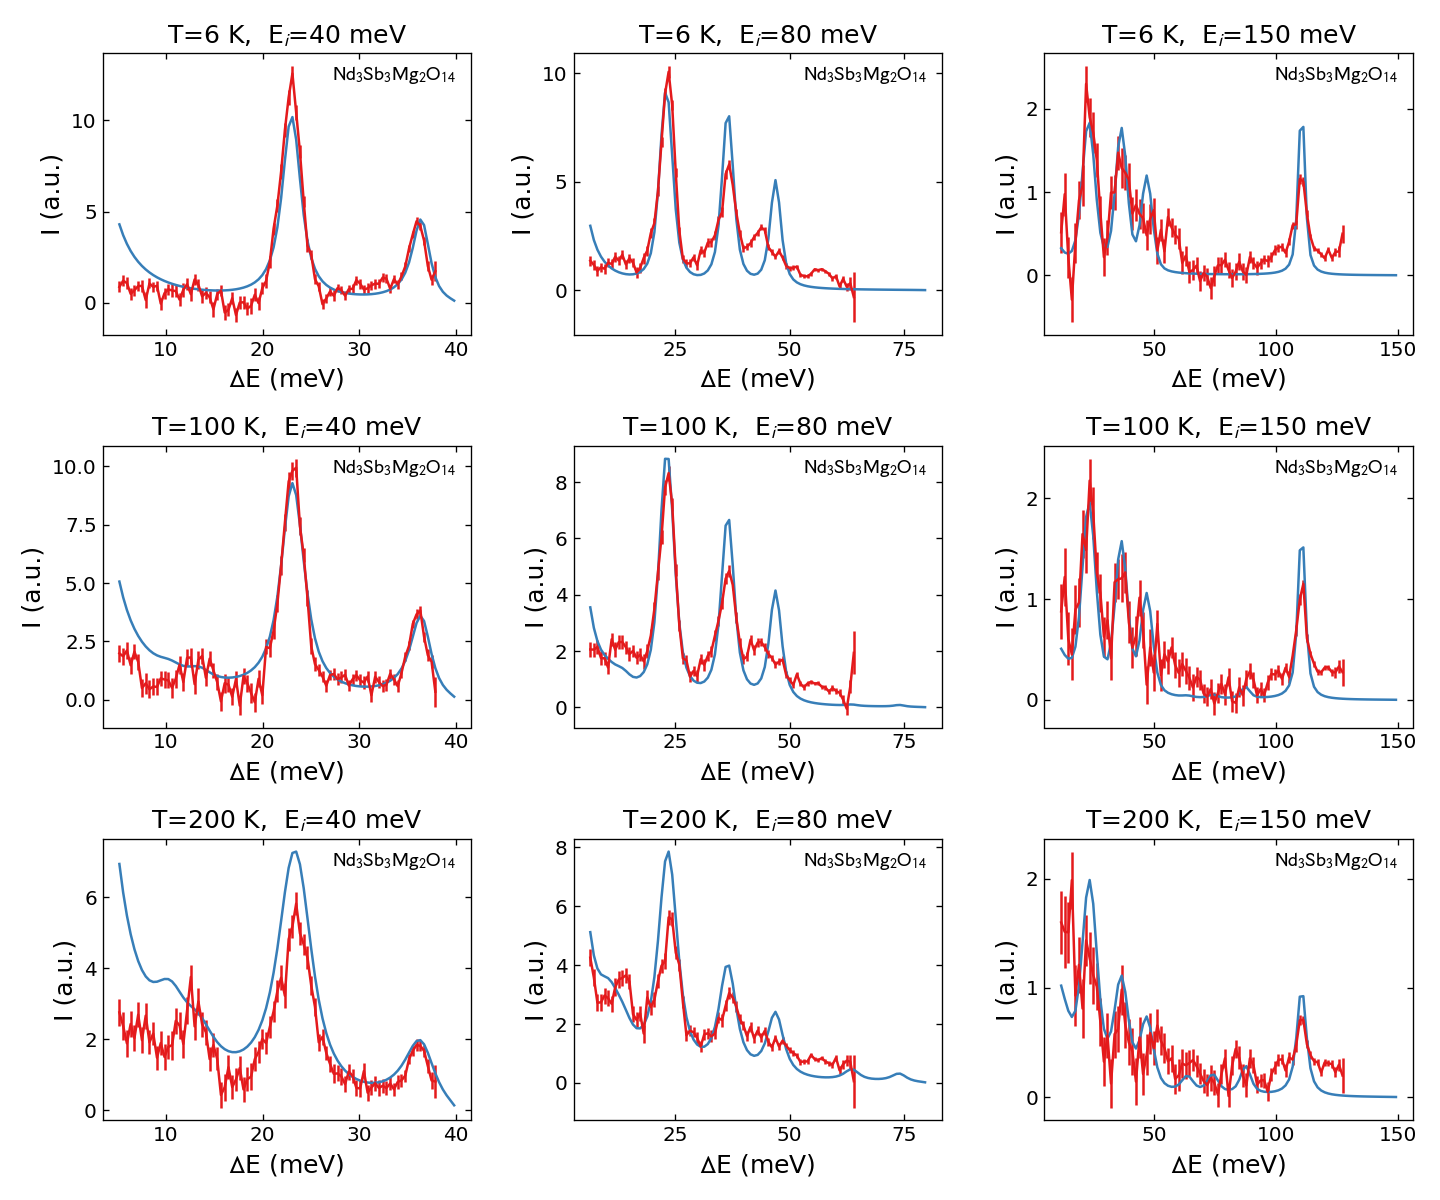

In [5]:

print(data[1]['Q'][5])
print(data[2]['Q'][9])
Qlim = {40:5, 80:5, 150:9}  #indices of the Q cuts that we want to plot


gammas = np.repeat(FitGamma, len(set(datatemps)))
prefc = np.tile(FitPrefactors, len(dataengys))
Nd_intens = []
Nd_fitx = []
for i, t in enumerate(datatemps):
    Nd_intens.append(prefc[i]*NdCoefFit1.neutronSpectrum2D(Earray=data[i]['E'], Qarray = data[i]['Q'], Temp=t, 
                                                Ei=dataengys[i], ResFunc=lambda de: resfunc(dataengys[i],de), 
                                                gamma=gammas[i],DebyeWaller = AtomDisp['NdMg'][t], Ion = 'Nd3+') )


f, ax = plt.subplots(3,3, figsize=(12,10))

multfac = 10000
for i in range(ntemps):
    for j in range(nengys):
        k = i*ntemps + j
        try: 
            ax[i,j].errorbar(data[k]['E'], multfac*data[k]['I'][:,Qlim[dataengys[k]]], 
                             multfac*data[k]['dI'][:,Qlim[dataengys[k]]])
            ax[i,j].plot(data[k]['E'], multfac*Nd_intens[k][:,Qlim[dataengys[k]]], lw=1.5)
            ax[i,j].set_ylabel('I (a.u.)',fontsize=15)
            ax[i,j].set_xlabel('$\Delta$E (meV)',fontsize=15)
            #ax[i,j].set_ylim(0,0.0006)
            #ax[i,j].legend(frameon=False, fontsize=14)
            ax[i,j].text(0.96,0.96,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$',
                horizontalalignment='right',verticalalignment='top', transform=ax[i,j].transAxes)
            ax[i,j].set_title('T='+str(datatemps[k])+' K,  '+'E$_i$='+str(dataengys[k])+' meV', fontsize=15)
        except IndexError:
            break

plt.tight_layout()
plt.show()



In [6]:
with open('CEF_fitResults.pickle', 'rb') as f:
    NdCoefFitSc, FitGamma, FitPrefactors = pickle.load(f)
    #NdCoefFit1, FitCoefficients, FitGamma, FitPrefactors = pickle.load(f)
# with open('NdMg_CEF_fitResults_FitSus.pickle', 'rb') as f:
#     NdCoefFit1, FitCoefficients, FitOcc, FitGamma, FitPrefactors = pickle.load(f)

NdCoefFitSc.diagonalize()
NdCoefFitSc.printEigenvectors()
NdCoefFitSc.gsExpectation()

NMcalcsuscep = NdCoefFitSc.susceptibility('Nd3+', Temp,  0.5, 0.001)


 Eigenvalues 	 Eigenvectors
		-----------------------------------------------------------------------------
0.00000 	|  [-0.006  0.319 -0.26  -0.034  0.168 -0.314  0.048 -0.152  0.823 -0.014]  |
0.00000 	|  [-0.014 -0.823 -0.152 -0.048 -0.314 -0.168 -0.034  0.26   0.319  0.006]  |
23.17589 	|  [-0.021  0.426 -0.281  0.189 -0.702  0.091 -0.241  0.378  0.016  0.   ]  |
23.17589 	|  [-0.     0.016 -0.378 -0.241 -0.091 -0.702 -0.189 -0.281 -0.426 -0.021]  |
36.37200 	|  [-0.083 -0.077 -0.654  0.49   0.282  0.088  0.426  0.133 -0.181  0.   ]  |
36.37200 	|  [-0.    -0.181 -0.133  0.426 -0.088  0.282 -0.49  -0.654  0.077 -0.083]  |
43.76415 	|  [-0.061  0.013  0.208  0.124 -0.523 -0.099  0.677 -0.442  0.013 -0.   ]  |
43.76415 	|  [ 0.     0.013  0.442  0.677  0.099 -0.523 -0.124  0.208 -0.013 -0.061]  |
110.69161 	|  [-0.     0.005 -0.005 -0.071 -0.001  0.027  0.051  0.051 -0.007 -0.994]  |
110.69161 	|  [ 0.994 -0.007 -0.051  0.051 -0.027 -0.001  0.071 -0.005 -0.005 -0.   ]  |
		---------

<IPython.core.display.Javascript object>


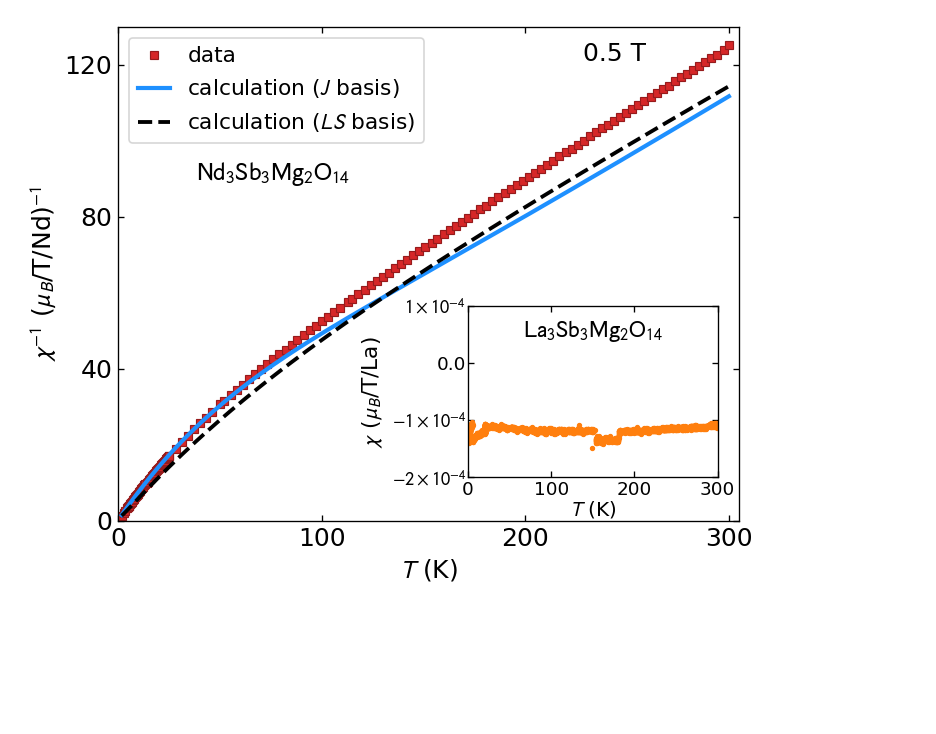

In [7]:
calcsuscep = NdCoefFit1.susceptibilityDeriv(Temp, 0.5, 0.001)

cpal = plt.cm.tab10(np.arange(10))
NMcol = cpal[3]


plt.rc('font',**{'size':15})
f, ax = plt.subplots(figsize=(6.5,5.1))

ax.plot(Temp,Chiminus1, 's', markersize=5,mew=0.7,mec=NMcol*np.array([0.7,0.7,0.7,1]), 
         c=NMcol, label='data')
ax.plot(Temp,-1/(NMcalcsuscep), label='calculation ($J$ basis)', c='dodgerblue', ls='-', lw=2.5)
ax.plot(Temp,-1/(calcsuscep), label='calculation ($LS$ basis)', c='k', ls='--', lw=2.3)
ax.text(0.25,0.73,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='top', transform=ax.transAxes)
ax.text(0.85,0.97, '0.5 T',
    horizontalalignment='right',verticalalignment='top', transform=ax.transAxes)
ax.legend(loc=2, handlelength=1.5, fontsize=13)

ax.set_ylabel('$\chi^{-1}$ ($\mu_B$/T/Nd)$^{-1}$')
ax.set_xlabel('$T$ (K)')
ax.set_xticks([0,100,200,300])
ax.set_yticks([0,40,80,120])
ax.set_xlim(0,305)
ax.set_ylim(0,130)
    
plt.tight_layout()
plt.subplots_adjust(hspace=0.01)


left, bottom, width, height = [0.6, 0.22, 0.32, 0.28]
inset = f.add_axes([left, bottom, width, height])

# inset.plot(Temp,1/Chiminus1, 's', markersize=5,mew=0.7,mec=NMcol*np.array([0.7,0.7,0.7,1]), 
#          c=NMcol, label='Nd data')
inset.plot(TempLa,1/Chiminus1La, '.', markersize=5,mew=0.7,c=cpal[1], label='La data')
# inset.plot(Temp,-(NMcalcsuscep), c='dodgerblue', ls='-', lw=2.5)
# inset.plot(Temp,-(calcsuscep), c='k', ls='--', lw=2.3)
inset.set_ylim(-0.0002, 0.0001)
inset.set_xlim(0, 300)

# inset.legend(loc=0, handlelength=1.0, fontsize=12)
# inset.set_yticks([0,0.02,0.04])
inset.set_yticklabels(['$-2\\times 10^{-4}$','$-1\\times 10^{-4}$',0.0, '$1\\times 10^{-4}$'])
inset.tick_params(axis='y', which='major', pad=1, labelsize=11)
inset.tick_params(axis='x', which='major', pad=2, labelsize=11)
inset.set_ylabel('$\chi$ ($\mu_B$/T/La)',fontsize=13)
inset.set_xlabel('$T$ (K)', fontsize=12, labelpad=0)
inset.text(0.5,0.93,'$\\rm{La_3Sb_3Mg_2O_{14}}$', fontsize=14,
        horizontalalignment='center',verticalalignment='top', transform=inset.transAxes)


<IPython.core.display.Javascript object>


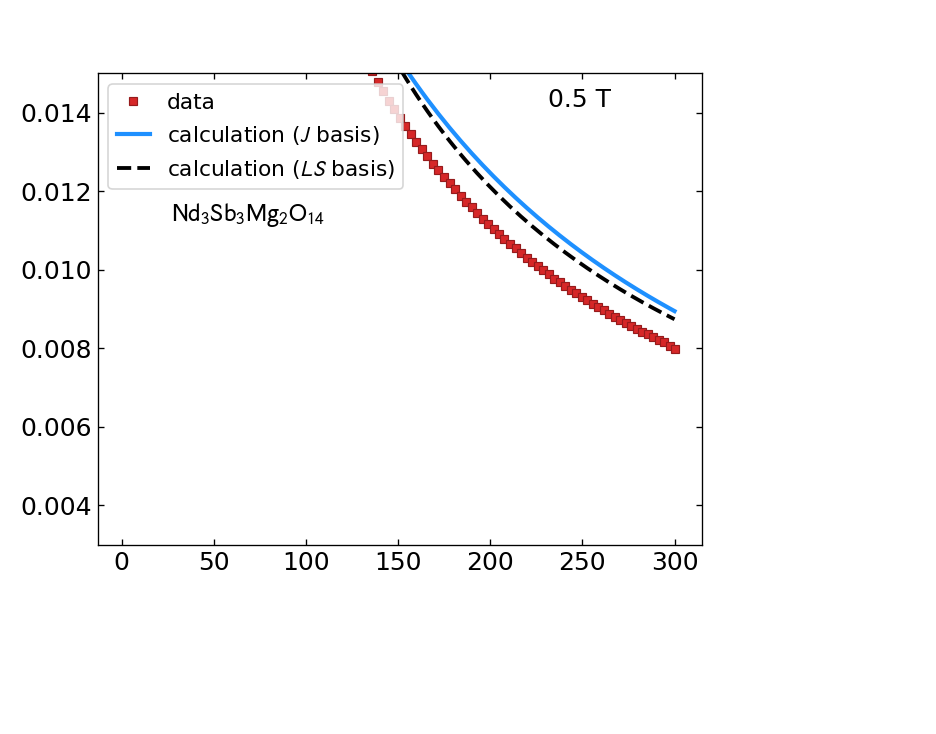

(0.003, 0.015)

In [8]:
f, ax = plt.subplots(figsize=(6.5,5.1))

ax.plot(Temp,1/Chiminus1, 's', markersize=5,mew=0.7,mec=NMcol*np.array([0.7,0.7,0.7,1]), 
         c=NMcol, label='data')
ax.plot(Temp,-(NMcalcsuscep), label='calculation ($J$ basis)', c='dodgerblue', ls='-', lw=2.5)
ax.plot(Temp,-(calcsuscep), label='calculation ($LS$ basis)', c='k', ls='--', lw=2.3)
ax.text(0.25,0.73,'$\\rm{Nd_3Sb_3Mg_2O_{14}}$',
        horizontalalignment='center',verticalalignment='top', transform=ax.transAxes)
ax.text(0.85,0.97, '0.5 T',
    horizontalalignment='right',verticalalignment='top', transform=ax.transAxes)
ax.legend(loc=2, handlelength=1.5, fontsize=13)
ax.set_ylim(0.003,0.015)

In [13]:
def printLaTexCEFparams(B1, B2, B3, B4, B5, B6):
    precision = 5
    '''prints CEF parameters in the output that Latex can read'''
    print('\\begin{table*}\n\\caption{Fitted vs. Calculated CEF parameters for $\\rm{Nd_3Sb_3Mg_2O_{14}}$}')
    print('\\begin{ruledtabular}')
    print('\\begin{tabular}{c|'+'c'*3+'|'+'c'*3+'}')
    # Create header
    print('$B_n^m$ (meV) &'+'Calculated ($J$) & Fitted PC ($J$) & Fitted ($J$)'+\
          '& Calculated ($LS$)  & Fitted PC ($LS$)  & Fitted ($LS$)'
        +' \\tabularnewline\n \\hline ')
    for i, (n,m) in enumerate([[n,m] for n in range(2,8,2) for m in range(0,n+1)]):
        print('$ B_'+str(n)+'^'+str(m)+'$ &', np.around(B1[i],decimals=precision),'&',
              np.around(B2[i],decimals=precision),'&',np.around(B3[i],decimals=precision),'&',
              np.around(B4[i],decimals=precision),'&',
              np.around(B5[i],decimals=precision),'&',np.around(B6[i],decimals=precision),
              '\\tabularnewline')
    print('\\end{tabular}\\end{ruledtabular}')
    print('\\label{flo:NdMg_CEF_params}\n\\end{table*}')

with open('NdMg_CEF_fitResults.pickle', 'rb') as f:
     OriginalNdCoefFit1, FitBJ, FitGammaJ, FitPrefactorsJ = pickle.load(f)
        
with open('NdMg_CEF_PC_fitResults.pickle', 'rb') as f:
     PCOriginalNdCoefFit1, PCFitBJ = pickle.load(f)
    
InitialBJ = np.array([  2.40045691e-01,  -1.59746462e+00,   1.45855501e-01,
        -3.94377579e-02,   5.45059980e-03,  -1.01920454e-02,
        -3.35185014e-01,   2.32319967e-02,  -5.28293040e-04,
         9.45057955e-05,   5.02038645e-04,   6.37635187e-03,
        -6.88198007e-04,  -1.64078977e-03,  -6.73673088e-03])

############################### LS
InitialBLS = np.array([  1.50885863e-01,  -1.00412062e+00,   9.16806007e-02,
        -1.65870570e-02,   2.29245815e-03,  -4.28665439e-03,
        -1.40974874e-01,   9.77110451e-03,  -1.55925500e-04,
         2.78933514e-05,   1.48176525e-04,   1.88197795e-03,
        -2.03121393e-04,  -4.84278508e-04,  -1.98834369e-03])

with open('/home/allen/Documents/Neutrons/Nd3Sb3Mg2O14/ARCS_Exp/intermediateCoupling/'+\
          'CEF_ND_PC_fitResults.pickle', 'rb') as f:
    PCLSNd3fit, PCLSFitVals, PCFitBLS = pickle.load(f)
    
FitBLS = FitCoefRes1['coeff']

printLaTexCEFparams(InitialBJ,PCFitBJ,FitBJ,InitialBLS,PCFitBLS,FitBLS)

\begin{table*}
\caption{Fitted vs. Calculated CEF parameters for $\rm{Nd_3Sb_3Mg_2O_{14}}$}
\begin{ruledtabular}
\begin{tabular}{c|ccc|ccc}
$B_n^m$ (meV) &Calculated ($J$) & Fitted PC ($J$) & Fitted ($J$)& Calculated ($LS$)  & Fitted PC ($LS$)  & Fitted ($LS$) \tabularnewline
 \hline 
$ B_2^0$ & 0.24005 & -0.18422 & -0.02534 & 0.15089 & -0.09273 & -0.11967 \tabularnewline
$ B_2^1$ & -1.59746 & -0.80356 & -1.04624 & -1.00412 & -0.60455 & -0.86278 \tabularnewline
$ B_2^2$ & 0.14586 & -0.00991 & 0.00786 & 0.09168 & -0.11516 & 0.03186 \tabularnewline
$ B_4^0$ & -0.03944 & -0.01916 & -0.01849 & -0.01659 & -0.00788 & -0.00593 \tabularnewline
$ B_4^1$ & 0.00545 & 0.00299 & 0.00886 & 0.00229 & 0.0017 & 0.00243 \tabularnewline
$ B_4^2$ & -0.01019 & -0.00441 & -0.00489 & -0.00429 & -0.00158 & -0.00168 \tabularnewline
$ B_4^3$ & -0.33519 & -0.15385 & 0.0413 & -0.14097 & -0.06406 & -0.04794 \tabularnewline
$ B_4^4$ & 0.02323 & 0.00993 & 0.01735 & 0.00977 & 0.00344 & 0.00525 \tabularnewline
$ B_6^0

## Test: is the ground state easy axis or easy plane?

In [10]:
# Compute Magnetization
temp = 2
fieldstrengths = np.arange(-9,9,0.05)
magnetization = np.zeros((len(fieldstrengths), 3, 3))
netmag = np.zeros(len(fieldstrengths))

theta, phi = 1, 1*np.pi/6
Bvect = np.array([np.cos(phi)*np.sin(theta), np.sin(phi)*np.sin(theta), np.cos(theta)])
Bvect = np.array([1,1,1])/np.sqrt(3)

for i, fs in enumerate(fieldstrengths):
    magnetization[i,0] = NdCoefFit1.magnetizationDeriv(temp, [fs,0,0], 0.001)
    magnetization[i,1] = NdCoefFit1.magnetizationDeriv(temp, [0,fs,0], 0.001)
    magnetization[i,2] = NdCoefFit1.magnetizationDeriv(temp, [0,0,fs], 0.001)
    netmag[i] = -np.dot(Bvect, np.array(NdCoefFit1.magnetizationDeriv(temp, fs*Bvect, 0.001)))
# plt.figure()
# plt.plot(fieldstrengths, netmag)

[[  1.28596879e-01   0.00000000e+00   1.12394609e+00]
 [  1.24741952e-09   4.95676896e-02   9.82026079e-10]
 [  1.50460800e-01   0.00000000e+00   2.74778135e+00]]


<IPython.core.display.Javascript object>


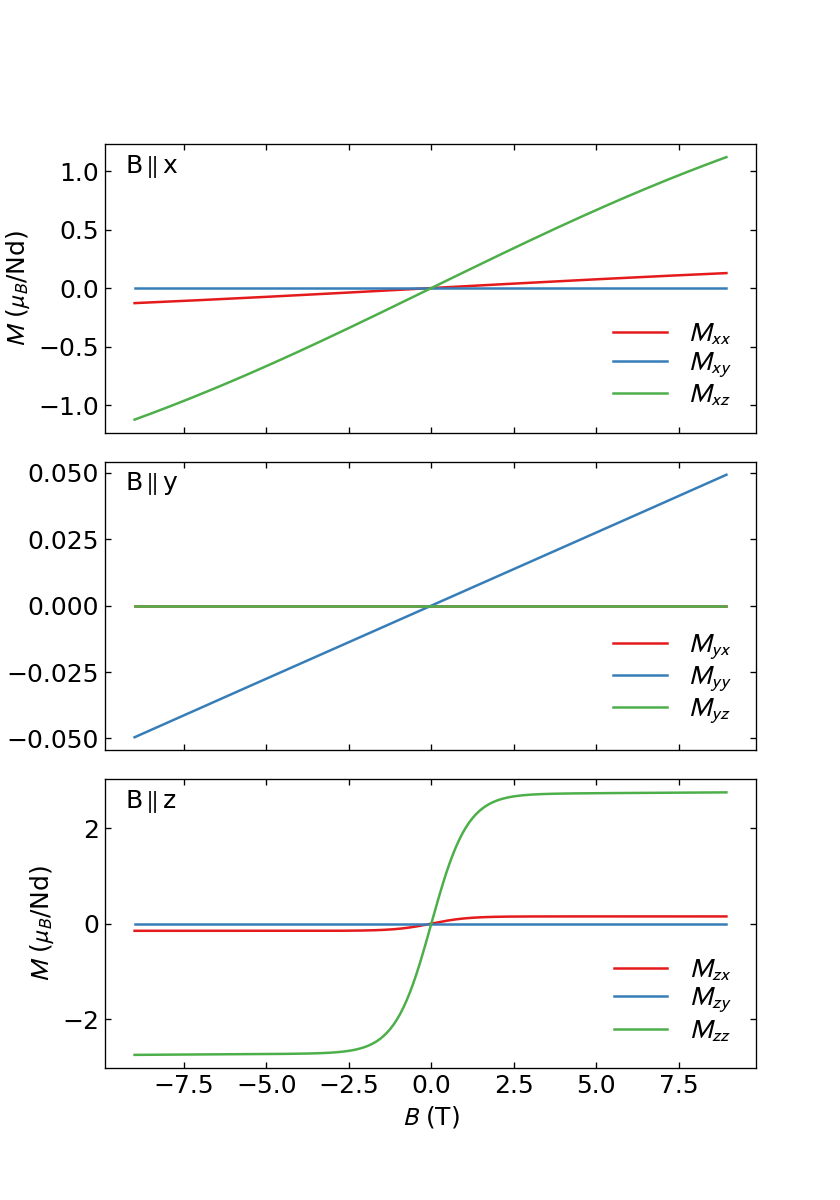

<IPython.core.display.Javascript object>


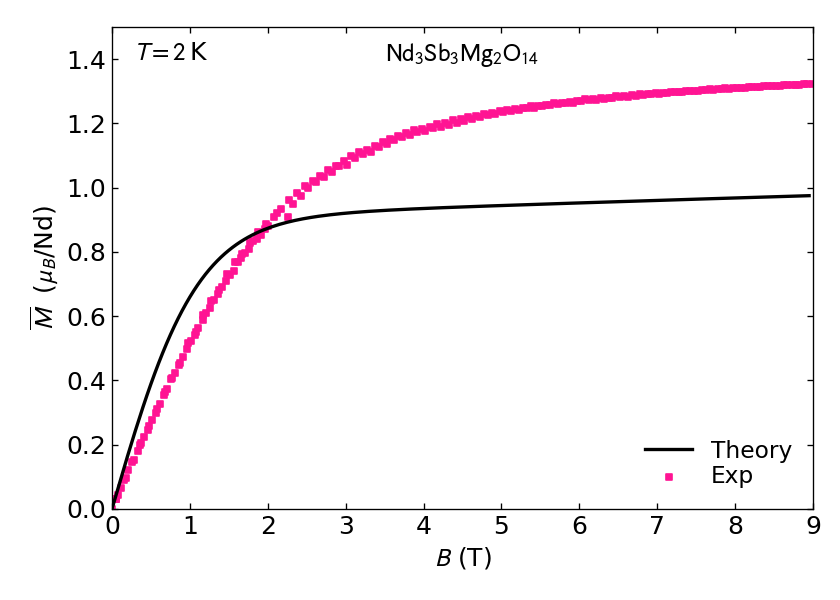

In [11]:
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'font.size': 15}
plt.rcParams.update(params)

f, ax = plt.subplots(3,1, figsize=(7,10), sharex=True)
direction = ['x','y','z']
for i in range(3):
    ax[i].plot(fieldstrengths,-magnetization[:,i,0], label='$M_{'+direction[i]+'x}$')
    ax[i].plot(fieldstrengths,-magnetization[:,i,1], label='$M_{'+direction[i]+'y}$')
    ax[i].plot(fieldstrengths,-magnetization[:,i,2], label='$M_{'+direction[i]+'z}$')
    ax[i].text(0.03,0.97,'B$\\parallel$'+direction[i],
                horizontalalignment='left',verticalalignment='top', transform=ax[i].transAxes)
    ax[i].legend(loc=4, frameon=False,labelspacing = 0.1, fontsize=16)
    ax[i].set_ylabel('$M$ ($\mu_B$/Nd)')

f.subplots_adjust(hspace=0.1)
ax[2].set_xlabel('$B$ (T)')

In [12]:
print(Field[110],NormMagB[110])

8.924693 1.32221992622
